In [8]:
import pandas as pd
import scipy.io

mat = scipy.io.loadmat('data-20.mat')  

label_map = ['2ASK', '2FSK', '2PSK', '4ASK', '4FSK', '4PSK', '8ASK', '8FSK', '8PSK', '16QAM', '64QAM']
label_map = dict(zip(range(11), label_map))
label_map

{0: '2ASK',
 1: '2FSK',
 2: '2PSK',
 3: '4ASK',
 4: '4FSK',
 5: '4PSK',
 6: '8ASK',
 7: '8FSK',
 8: '8PSK',
 9: '16QAM',
 10: '64QAM'}

In [9]:
# As 963 amostras temporais vem na forma colunar, gostaríamos de colocá-los por linhas, 
# este passo então irá colocar a cada linha uma amostra do sinal temporal, bem como sua categoria

all_dfs = []
for i in range(22000):
    df = pd.DataFrame(mat['Qt'][0][i][0], columns = ['realizations', 'labels']).T
    df['label'] = df.loc['labels'][0]
    df = df.drop(['labels'], axis=0)
    all_dfs.append(df)

In [10]:
data = pd.concat(all_dfs)
data = data.reset_index(drop=True)
data.head(4)

,0,1,2,3,4,5,6,7,8,9,...,951,952,953,954,955,956,957,958,959,label
0,0.921217,0.803038,0.491532,0.208562,0.086520,0.248143,0.502702,0.819148,0.901632,0.829753,...,0.500987,0.485782,0.511074,0.488014,0.516505,0.490299,0.538018,0.492046,0.520091,0.0
1,0.892224,0.815750,0.753137,0.616349,0.519718,0.354897,0.206726,0.126004,0.069782,0.146352,...,0.124305,0.099053,0.147366,0.201713,0.333098,0.470239,0.615776,0.780167,0.801813,1.0
2,0.100278,0.206419,0.481453,0.814832,0.877386,0.811196,0.476648,0.246302,0.132824,0.242272,...,0.241254,0.135121,0.254624,0.531662,0.768043,0.916900,0.806206,0.504862,0.271037,2.0
3,0.923296,0.785511,0.495592,0.173308,0.072856,0.174115,0.491491,0.795850,0.932013,0.798940,...,0.591157,0.618227,0.579647,0.515496,0.390316,0.347259,0.439745,0.481240,0.613528,3.0


In [11]:
X = data[[col for col in data.columns if col!='label']]
y = data.label

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.50, random_state=42)
X_train.shape, X_test.shape

((11000, 960), (11000, 960))

In [12]:
import torch
import torch.utils.data
import numpy as np

train = torch.tensor(X_train.values[:,np.newaxis].astype(np.float32))
train_target = torch.tensor(y_train.values[:,np.newaxis].astype(np.float32))
train_target = train_target.type(torch.LongTensor)

test = torch.tensor(X_test.values[:,np.newaxis].astype(np.float32))
test_target = torch.tensor(y_test.values[:,np.newaxis].astype(np.float32))
test_target = test_target.type(torch.LongTensor)

train_tensor = torch.utils.data.TensorDataset(train, train_target) 
test_tensor = torch.utils.data.TensorDataset(test, test_target) 

trainloader = torch.utils.data.DataLoader(dataset=train_tensor, 
                                          batch_size=64, shuffle=True)

testloader = torch.utils.data.DataLoader(dataset=test_tensor, 
                                          batch_size=64, shuffle=True)

In [13]:
from torch import nn, optim
import torch.nn.functional as F

# define the CNN architecture
class ConvNet(nn.Module):
    def __init__(self):
        super(ConvNet, self).__init__()
        # convolutional layer
        self.conv1 = nn.Conv1d(1, 8, 3, padding=1)
        # max pooling layer
        self.conv2 = nn.Conv1d(8, 4, 3, padding = 1)
        self.conv3 = nn.Conv1d(4, 1, 3, padding = 1)

        self.linear1 = nn.Linear(960, 512)
        self.classifier = nn.Linear(512, 11)
        
        self.drop_out = nn.Dropout(0.2)
        
        

    def forward(self, x):
        # add sequence of convolutional and max pooling layers
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv3(x))
        x = x.view(-1, 960)
        x = self.drop_out(x)
        x = F.relu(self.linear1(x))
        x = F.log_softmax(self.classifier(x), dim=1)
        
        return x

# create a complete CNN
model = ConvNet()
print(model)

if True:
    model.cuda()

ConvNet(
  (conv1): Conv1d(1, 8, kernel_size=(3,), stride=(1,), padding=(1,))
  (conv2): Conv1d(8, 4, kernel_size=(3,), stride=(1,), padding=(1,))
  (conv3): Conv1d(4, 1, kernel_size=(3,), stride=(1,), padding=(1,))
  (linear1): Linear(in_features=960, out_features=512, bias=True)
  (classifier): Linear(in_features=512, out_features=11, bias=True)
  (drop_out): Dropout(p=0.2)
)


In [14]:
train_on_gpu = torch.cuda.is_available()
if train_on_gpu:
    print('Vamos la!')
# specify loss function
criterion = nn.NLLLoss()

# specify optimizer
optimizer = optim.Adam(model.parameters(), lr=0.001)

# number of epochs to train the model
n_epochs = 40 # you may increase this number to train a final model

valid_loss_min = np.Inf # track change in validation loss

train_losses, test_losses = [], []
for epoch in range(1, n_epochs+1):
    accuracy = 0
    # keep track of training and validation loss
    train_loss = 0.0
    valid_loss = 0.0
    
    ###################
    # train the model #
    ###################
    model.train()
    for data, target in trainloader:
        # move tensors to GPU if CUDA is available
        if train_on_gpu:
            data, target = data.cuda(), target.cuda()
        # clear the gradients of all optimized variables
        optimizer.zero_grad()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        # calculate the batch loss
        target = target.view(-1)

        loss = criterion(output, target)
        # backward pass: compute gradient of the loss with respect to model parameters
        loss.backward()
        # perform a single optimization step (parameter update)
        optimizer.step()
        # update training loss
        train_loss += loss.item()*data.size(0)
        
    ######################    
    # validate the model #
    ######################
    model.eval()
    with torch.no_grad():
        for data, target in testloader:
            # move tensors to GPU if CUDA is available
            if train_on_gpu:
                data, target = data.cuda(), target.cuda()
            # forward pass: compute predicted outputs by passing inputs to the model
            target = target.view(-1)
            output = model(data)
            # calculate the batch loss
            loss = criterion(output, target)
            # update average validation loss 
            valid_loss += loss.item()*data.size(0)

            ps = torch.exp(output)

            top_p, top_class = ps.topk(1, dim=1)
            equals = top_class == target.view(*top_class.shape)

            accuracy += torch.mean(equals.type(torch.FloatTensor))

    accuracy /= len(testloader)
    # calculate average losses
    train_loss = train_loss/len(trainloader.dataset)
    valid_loss = valid_loss/len(testloader.dataset)
    
    train_losses.append(train_loss)
    test_losses.append(valid_loss)
    
    print(f'Accuracy: {accuracy.item()*100}%')
    
    # print training/validation statistics 
    print('Epoch: {} \tTraining Loss: {:.6f} \t'.format(
        epoch, train_loss))
    
     # save model if validation loss has decreased
    if valid_loss <= valid_loss_min:
        print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
        valid_loss_min,
        valid_loss))
        torch.save(model.state_dict(), 'model_cifar.pt')
        valid_loss_min = valid_loss

Vamos la!
Accuracy: 47.76266813278198%
Epoch: 1 	Training Loss: 1.661849 	
Validation loss decreased (inf --> 1.030096).  Saving model ...
Accuracy: 61.810892820358276%
Epoch: 2 	Training Loss: 0.888996 	
Validation loss decreased (1.030096 --> 0.753648).  Saving model ...
Accuracy: 67.092764377594%
Epoch: 3 	Training Loss: 0.680980 	
Validation loss decreased (0.753648 --> 0.659251).  Saving model ...
Accuracy: 69.41964626312256%
Epoch: 4 	Training Loss: 0.637107 	
Validation loss decreased (0.659251 --> 0.638696).  Saving model ...
Accuracy: 78.65707874298096%
Epoch: 5 	Training Loss: 0.563395 	
Validation loss decreased (0.638696 --> 0.504159).  Saving model ...
Accuracy: 81.55497312545776%
Epoch: 6 	Training Loss: 0.439717 	
Validation loss decreased (0.504159 --> 0.383246).  Saving model ...
Accuracy: 83.57558250427246%
Epoch: 7 	Training Loss: 0.378999 	
Validation loss decreased (0.383246 --> 0.345401).  Saving model ...
Accuracy: 83.65215063095093%
Epoch: 8 	Training Loss: 0.35

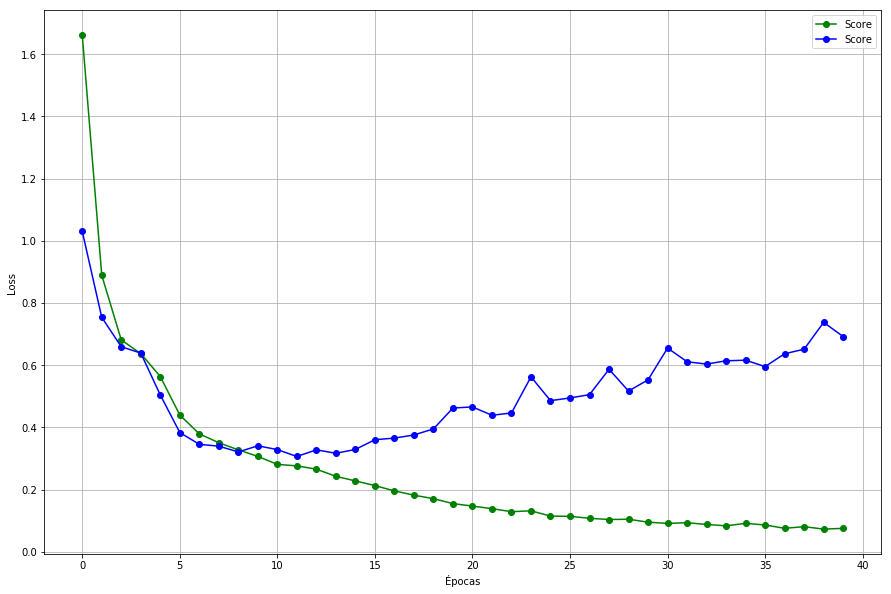

In [15]:
import matplotlib.pyplot as plt

%matplotlib inline

fig, ax = plt.subplots()

ax.plot(list(range(len(train_losses))), train_losses, 'g-o', label = 'Score')
ax.plot(list(range(len(test_losses))), test_losses, 'b-o', label = 'Score', )
ax.legend()
ax.set_xlabel('Épocas')
ax.set_ylabel('Loss')
ax.grid()

fig.set_figheight(10)
fig.set_figwidth(15)

In [16]:
# track test loss
model = ConvNet()
model.load_state_dict(torch.load('model_cifar.pt'))
model.cuda()

test_loss = 0.0
class_correct = list(0. for i in range(11))
class_total = list(0. for i in range(11))
batch_size = 8

classes = list(label_map.values())

model.eval()
# iterate over test data
for data, target in testloader:
    # move tensors to GPU if CUDA is available
    if train_on_gpu:
        data, target = data.cuda(), target.cuda()
    target = target.view(-1)
    # forward pass: compute predicted outputs by passing inputs to the model
    output = model(data)
    # calculate the batch loss
    loss = criterion(output, target)
    # update test loss 
    test_loss += loss.item()*data.size(0)
    # convert output probabilities to predicted class
    _, pred = torch.max(output, 1)    
    # compare predictions to true label
    correct_tensor = pred.eq(target.data.view_as(pred))
    correct = np.squeeze(correct_tensor.numpy()) if not train_on_gpu else np.squeeze(correct_tensor.cpu().numpy())
    # calculate test accuracy for each object class
    for i in range(batch_size):
        label = target.data[i]
        class_correct[label] += correct[i].item()
        class_total[label] += 1

# average test loss
test_loss = test_loss/len(testloader.dataset)
print('Test Loss: {:.6f}\n'.format(test_loss))

for i in range(10):
    if class_total[i] > 0:
        print('Test Accuracy of %5s: %2d%% (%2d/%2d)' % (
            classes[i], 100 * class_correct[i] / class_total[i],
            np.sum(class_correct[i]), np.sum(class_total[i])))
    else:
        print('Test Accuracy of %5s: N/A (no training examples)' % (classes[i]))

print('\nTest Accuracy (Overall): %2d%% (%2d/%2d)' % (
    100. * np.sum(class_correct) / np.sum(class_total),
    np.sum(class_correct), np.sum(class_total)))

Test Loss: 0.306237

Test Accuracy of  2ASK: 100% (126/126)
Test Accuracy of  2FSK: 100% (116/116)
Test Accuracy of  2PSK: 100% (117/117)
Test Accuracy of  4ASK: 94% (127/135)
Test Accuracy of  4FSK: 100% (133/133)
Test Accuracy of  4PSK: 100% (104/104)
Test Accuracy of  8ASK: 83% (108/129)
Test Accuracy of  8FSK: 98% (112/114)
Test Accuracy of  8PSK: 66% (86/129)
Test Accuracy of 16QAM: 44% (62/140)

Test Accuracy (Overall): 83% (1147/1376)


In [17]:
predicted = []
true = []
with torch.no_grad():
    for data, labels in testloader:
        model.eval()
        if train_on_gpu:
            data, labels = data.cuda(), labels.cuda()
        output = model(data)
        
        labels = labels.view(-1)
        true.extend(list(labels.tolist()))
        loss = criterion(output, labels)
        ps = torch.exp(output)
        
        top_p, top_class = ps.topk(1, dim=1)
        equals = top_class == labels.view(*top_class.shape)
        predicted.extend(list(top_class.view(-1).tolist()))

        accuracy += torch.mean(equals.type(torch.FloatTensor))

        
    accuracy /= len(testloader)
    print(len(testloader))
    print(f'Accuracy: {accuracy.item()*100}%')

172
Accuracy: 85.71568131446838%


Normalized confusion matrix


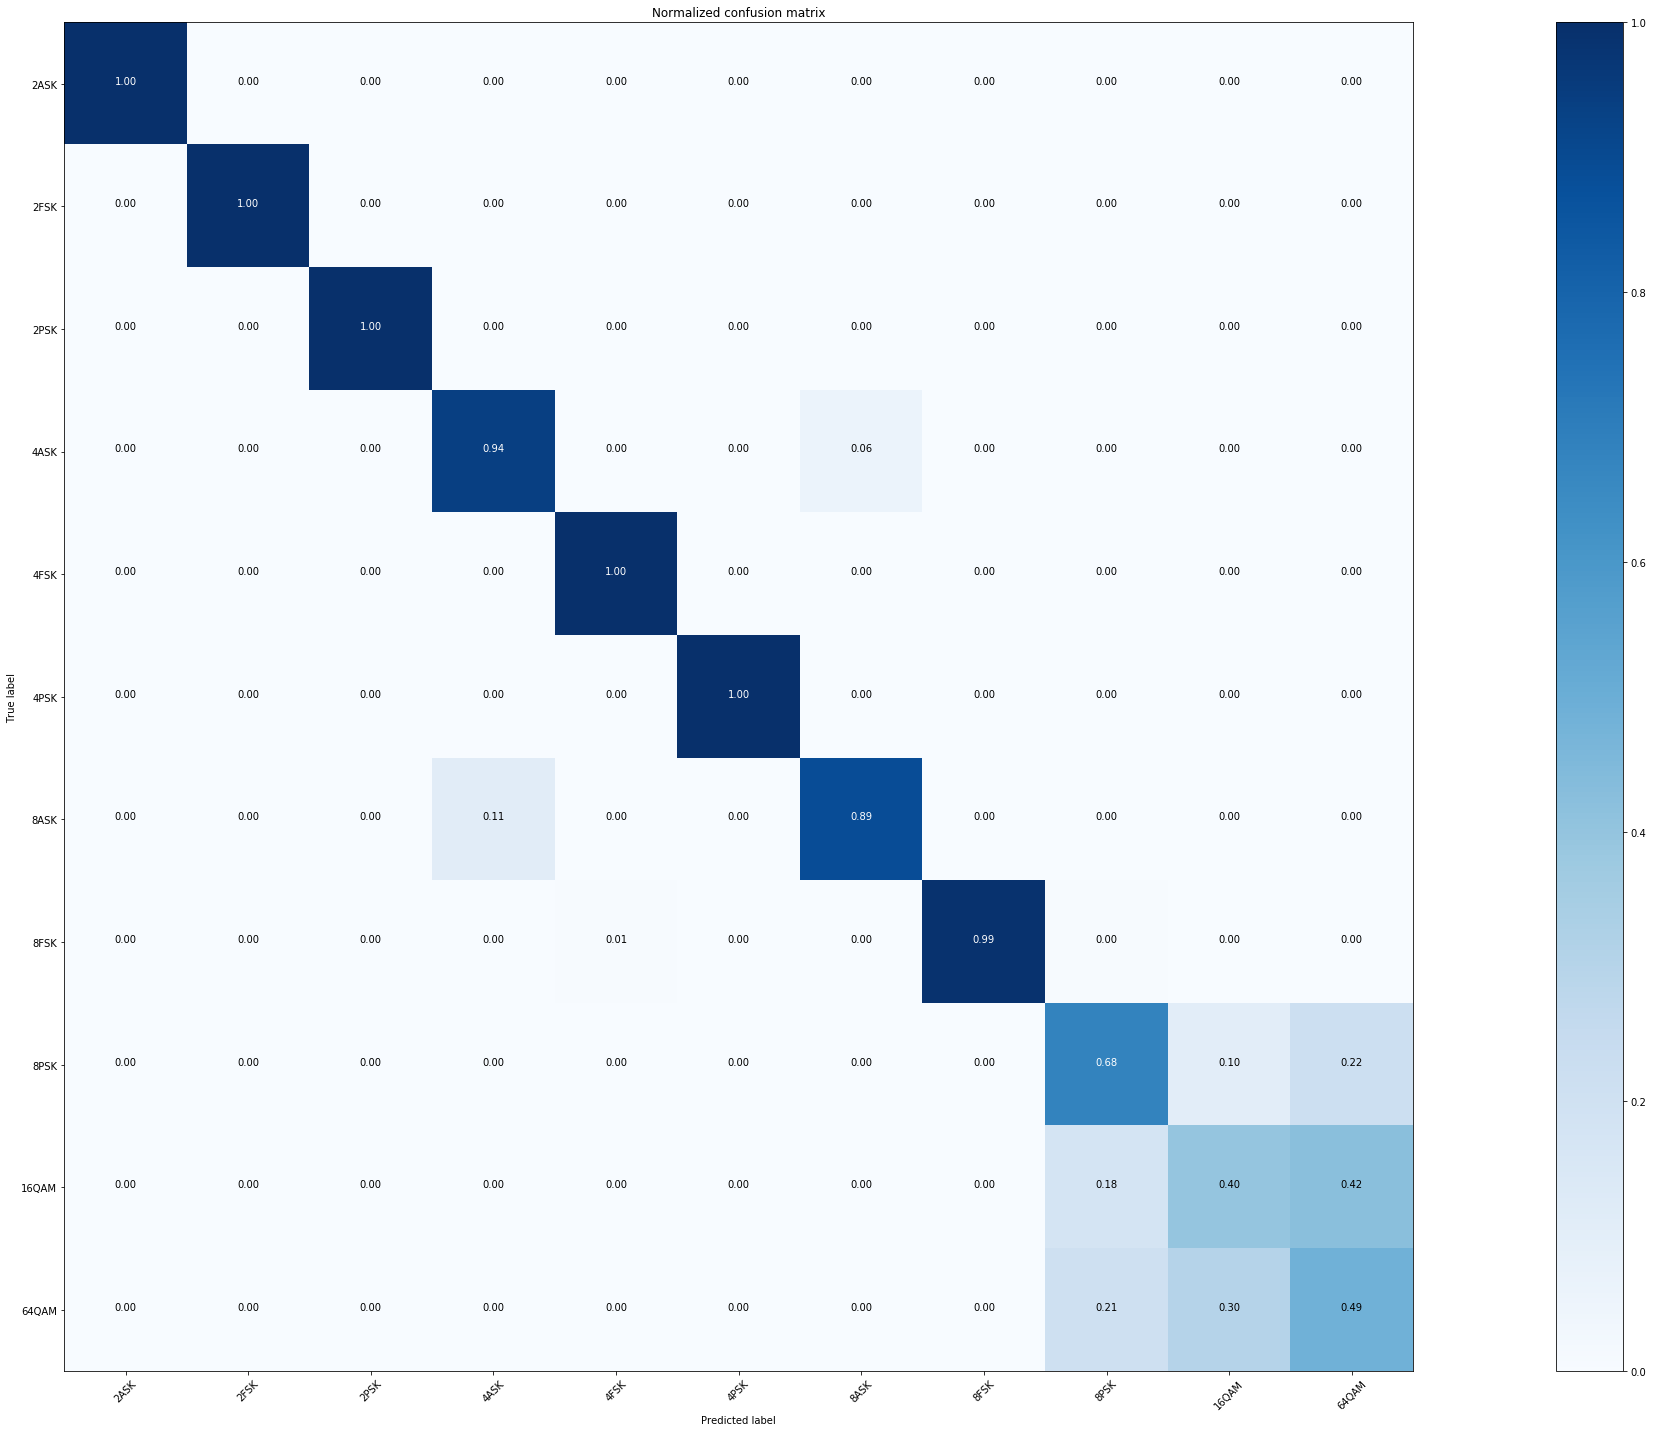

In [18]:
import itertools
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt

%matplotlib inline

class_names = label_map.values()# svm.classes_
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')


    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()


# Compute confusion matrix
cnf_matrix = confusion_matrix(true, predicted)
np.set_printoptions(precision=2)

# Plot normalized confusion matrix
plt.figure(figsize=(40,20))
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')

plt.show()

In [1]:
# Para cada vez que treinar a rede, anote a acurácia para o respectivo valor de SNR. Necessário pois por memõria limitada não conseguimos
# carregar todos os dados de uma vez.

scores_cnn = {}
scores_cnn['0'] = 0.854
scores_cnn['4'] = 0.8060
scores_cnn['8'] = 0.8141
scores_cnn['12'] = 0.89
scores_cnn['16'] = 0.87
scores_cnn['20'] = 0.88

In [6]:
scores_nn = {}
scores_nn['0'] = 0.74
scores_nn['4'] = 0.73
scores_nn['8'] = 0.77
scores_nn['12'] = 0.75
scores_nn['16'] = 0.78
scores_nn['20'] = 0.79

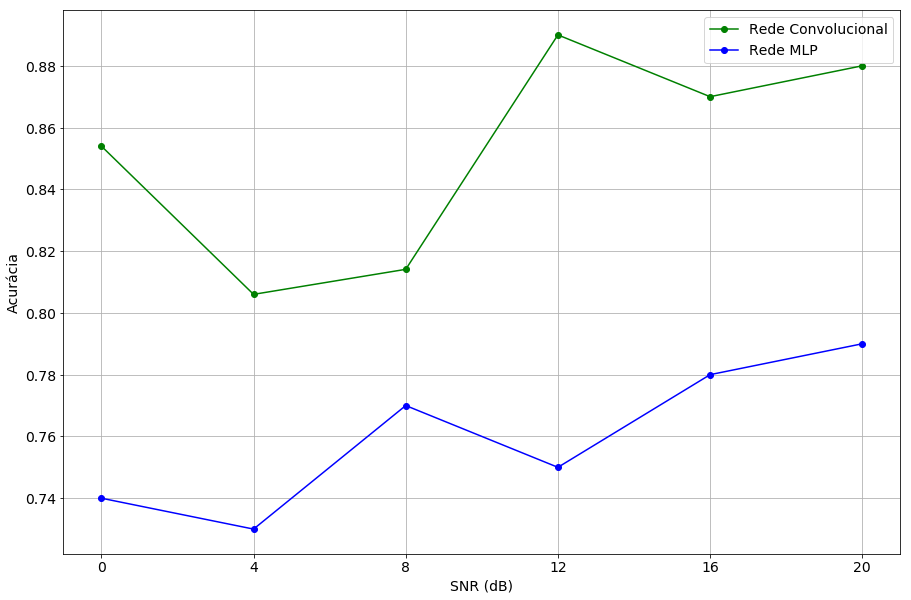

In [7]:
import matplotlib.pyplot as plt

%matplotlib inline

plt.rcParams.update({'font.size': 14})

fig, ax = plt.subplots()

ax.plot(scores_cnn.keys(), scores_cnn.values(), 'g-o', label = 'Rede Convolucional')
ax.plot(scores_nn.keys(), scores_nn.values(), 'b-o', label = 'Rede MLP', )
ax.legend()
ax.set_xlabel('SNR (dB)')
ax.set_ylabel('Acurácia')
ax.grid()

fig.set_figheight(10)
fig.set_figwidth(15)